# Hedge Ratio Visualization (Gap-Free & Multiple Examples)

This notebook:
1. Loads the results from `daily_cointegration_results_gpu.pkl`.
2. Defines a robust plotting function that **removes time gaps** (weekends).
3. Visualizes the **Best Historic Opportunity**.
4. Visualizes **10 Random Examples** from the significant results.

In [ ]:
import pickle
import cudf
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from pathlib import Path
from datetime import timedelta
import matplotlib.dates as mdates

# Configuration
DATA_DIR = Path("/mnt/ssd2/DARWINEX_Mission/data")
RESULTS_FILE = Path("/mnt/ssd2/DARWINEX_Mission/cointegration/results/daily_cointegration_results_gpu.pkl")

if not RESULTS_FILE.exists():
    raise FileNotFoundError("Please run cointegration_analysis.py first!")

## 1. Data Loading & Processing Functions

In [20]:
def load_pair_data(data_dir, p1, p2, start, end):
    """Loads data for two pairs, aligning them and dropping duplicates."""
    files = list(data_dir.glob("DAT_ASCII_*.csv"))
    p1_file = next((f for f in files if p1.upper() in f.name), None)
    p2_file = next((f for f in files if p2.upper() in f.name), None)
    
    if not p1_file or not p2_file:
        return None

    def read_clean(f, name):
        try:
            df = cudf.read_csv(
                f, sep=';', header=None, 
                names=['dt', 'o', 'h', 'l', 'close', 'v'],
                usecols=['dt', 'close'], dtype={'dt': 'str', 'close': 'float32'}
            )
            df['timestamp'] = cudf.to_datetime(df['dt'], format='%Y%m%d %H%M%S')
            # Drop duplicates to prevent merge errors
            df = df.drop_duplicates(subset=['timestamp'], keep='first')
            df = df.drop(columns=['dt']).set_index('timestamp').sort_index()
            df.columns = [name]
            return df
        except Exception:
            return None

    df1 = read_clean(p1_file, p1)
    df2 = read_clean(p2_file, p2)
    
    if df1 is None or df2 is None:
        return None
    
    # Join and Fill
    df = cudf.concat([df1, df2], axis=1).ffill().bfill()
    df = df.loc[start:end]
    return df

def calculate_beta(df, p1, p2):
    """Calculates Hedge Ratio (Beta) using OLS on GPU."""
    y_vals = df[p1].values
    x_vals = df[p2].values
    
    Y = cp.asarray(y_vals)
    X = cp.asarray(x_vals)
    
    mean_x = cp.mean(X)
    mean_y = cp.mean(Y)
    
    num = cp.sum((X - mean_x) * (Y - mean_y))
    den = cp.sum((X - mean_x) ** 2)
    
    beta = num / den
    alpha = mean_y - beta * mean_x
    return float(beta), float(alpha)

def process_and_plot(day_meta, record, title_prefix="Example"):
    """Runs the full analysis pipeline for a single record and plots the result."""
    pair1 = record['pair1']
    pair2 = record['pair2']
    score = record['score']
    
    is_start = day_meta['window_start']
    is_end = day_meta['day_end']
    oos_end = is_end + timedelta(days=1)
    
    # Load Data
    df_gpu = load_pair_data(DATA_DIR, pair1, pair2, is_start, oos_end)
    if df_gpu is None or len(df_gpu) < 100:
        print(f"Skipping {pair1}-{pair2}: Insufficient data.")
        return
    
    # Split IS/OOS
    df_is = df_gpu.loc[is_start:is_end]
    
    if len(df_is) < 10:
        print("Skipping: Not enough In-Sample data.")
        return

    # Calculate Beta on IS
    beta, alpha = calculate_beta(df_is, pair1, pair2)
    
    # Calculate Spread (CPU/Pandas for plotting)
    df_pd = df_gpu.to_pandas()
    spread = df_pd[pair1] - (beta * df_pd[pair2] + alpha)
    
    # --- PLOTTING WITHOUT GAPS ---
    plt.figure(figsize=(15, 6))
    
    # X-axis: Integer range
    x_vals = np.arange(len(spread))
    
    # Find the index where IS ends
    # We look for the last timestamp <= is_end
    is_indices = df_pd.index <= is_end
    if not any(is_indices):
        split_idx = 0
    else:
        split_idx = np.sum(is_indices) - 1
        
    # Plot Spread
    plt.plot(x_vals, spread.values, color='black', linewidth=1, label='Spread')
    
    # Background Colors
    plt.axvspan(0, split_idx, color='green', alpha=0.1, label='In-Sample (Train)')
    plt.axvspan(split_idx, len(x_vals)-1, color='orange', alpha=0.1, label='Out-of-Sample (Test)')
    
    # Mean Reversion Line (IS Mean)
    is_mean = spread.iloc[:split_idx+1].mean()
    plt.axhline(is_mean, color='blue', linestyle='--', alpha=0.5, label='IS Mean')
    
    # Vertical Separator
    plt.axvline(split_idx, color='red', linestyle='--', linewidth=2)
    
    # Custom X-Ticks (Dates)
    # Show ~10 ticks max to avoid crowding
    n_ticks = 10
    tick_step = max(1, len(spread) // n_ticks)
    tick_idxs = list(range(0, len(spread), tick_step))
    tick_labels = [spread.index[i].strftime('%Y-%m-%d\n%H:%M') for i in tick_idxs]
    
    plt.xticks(tick_idxs, tick_labels, rotation=0, fontsize=8)
    
    plt.title(f"{title_prefix}: {pair1} vs {pair2} | Score: {score:.2f} | Beta: {beta:.4f}")
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. Load Results & Identify Best Pair

In [21]:
with open(RESULTS_FILE, 'rb') as f:
    daily_results = pickle.load(f)

# Flatten list: (day_meta, pair_result)
all_opportunities = []
for day in daily_results:
    if day and 'results' in day:
        for res in day['results']:
            if res['is_significant_5pct']:
                all_opportunities.append((day, res))

print(f"Found {len(all_opportunities)} significant opportunities total.")

# Sort by score (ascending, more negative is better)
all_opportunities.sort(key=lambda x: x[1]['score'])

best_day, best_record = all_opportunities[0]
print(f"Best Overall: {best_record['pair1']} vs {best_record['pair2']} (Score: {best_record['score']:.4f})")

Found 44518 significant opportunities total.
Best Overall: cadjpy vs usdjpy (Score: -15.9117)


## 3. Visualize: Best Historic Opportunity

/tmp/ipykernel_108095/3197342253.py:125: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/edoardo/miniconda/envs/rapids-23.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


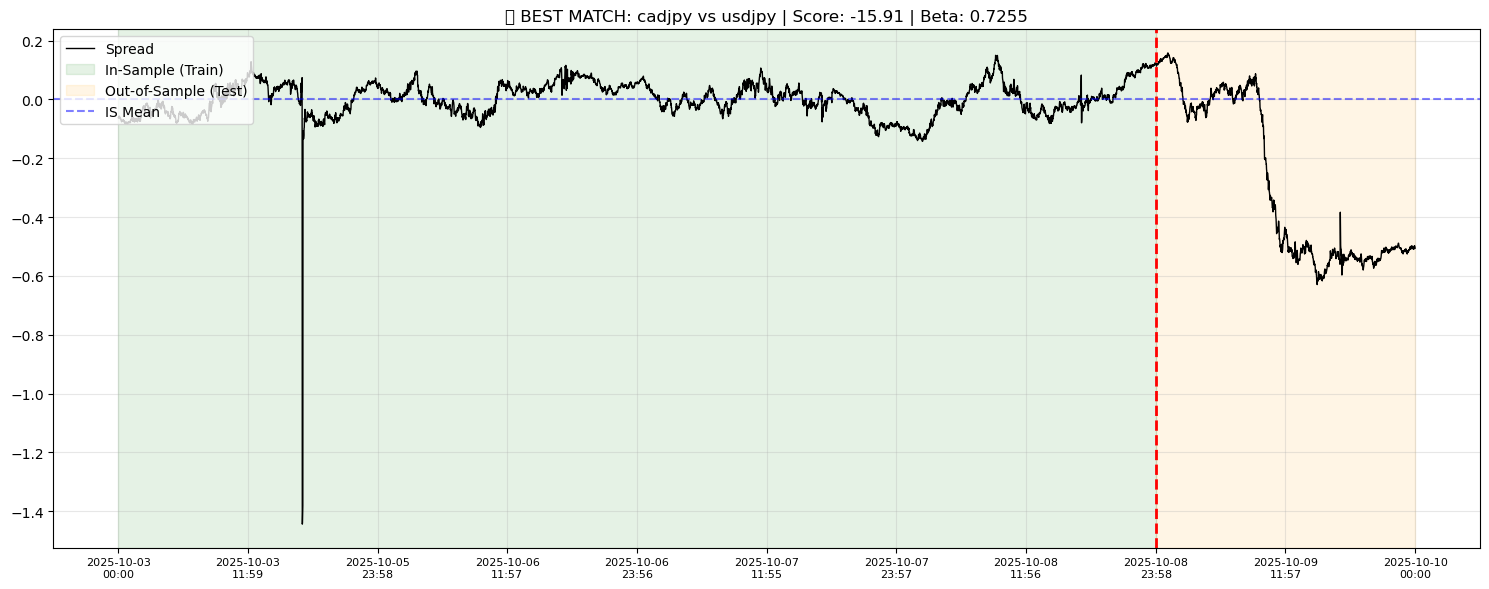

In [22]:
process_and_plot(best_day, best_record, title_prefix="🏆 BEST MATCH")

## 4. Visualize: Top 20 Pairs by Average Score

Calculating the average cointegration score for all pairs over the entire history,
selecting the Top 20, and visualizing a random period for each.

Calculating average scores for all pairs...

Top 20 Pairs by Average Cointegration Score (over 359 days):
1. audchf-euraud: Mean=-4.2946 (Days=359)
2. cadchf-eurcad: Mean=-4.2269 (Days=359)
3. audjpy-nzdjpy: Mean=-4.1458 (Days=359)
4. eurgbp-gbpchf: Mean=-3.8564 (Days=359)
5. chfjpy-eurjpy: Mean=-3.8205 (Days=359)
6. cadchf-eurchf: Mean=-3.8022 (Days=359)
7. cadchf-usdchf: Mean=-3.7995 (Days=359)
8. audchf-cadchf: Mean=-3.7783 (Days=359)
9. audnzd-cadchf: Mean=-3.6990 (Days=359)
10. eurchf-gbpchf: Mean=-3.6937 (Days=359)
11. audchf-eurnzd: Mean=-3.6263 (Days=359)
12. cadchf-gbpchf: Mean=-3.6076 (Days=359)
13. audchf-nzdjpy: Mean=-3.6074 (Days=359)
14. cadchf-gbpcad: Mean=-3.5910 (Days=359)
15. audchf-gbpaud: Mean=-3.5652 (Days=359)
16. audnzd-eurchf: Mean=-3.5650 (Days=359)
17. cadchf-eurgbp: Mean=-3.5558 (Days=359)
18. chfjpy-gbpjpy: Mean=-3.5496 (Days=359)
19. audchf-audnzd: Mean=-3.5368 (Days=359)
20. cadchf-cadjpy: Mean=-3.5289 (Days=359)

Visualizing Random Periods for Top 20 Pair

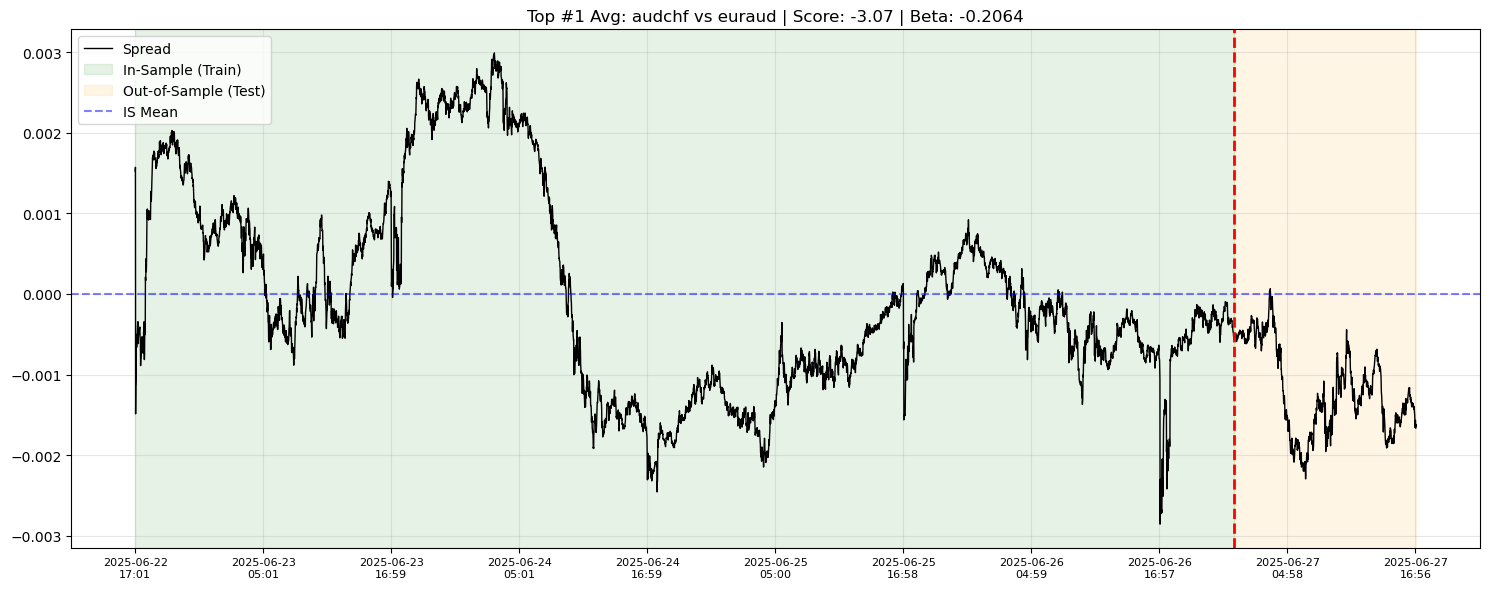


--- Rank 2: cadchf-eurcad (Mean: -4.23) ---


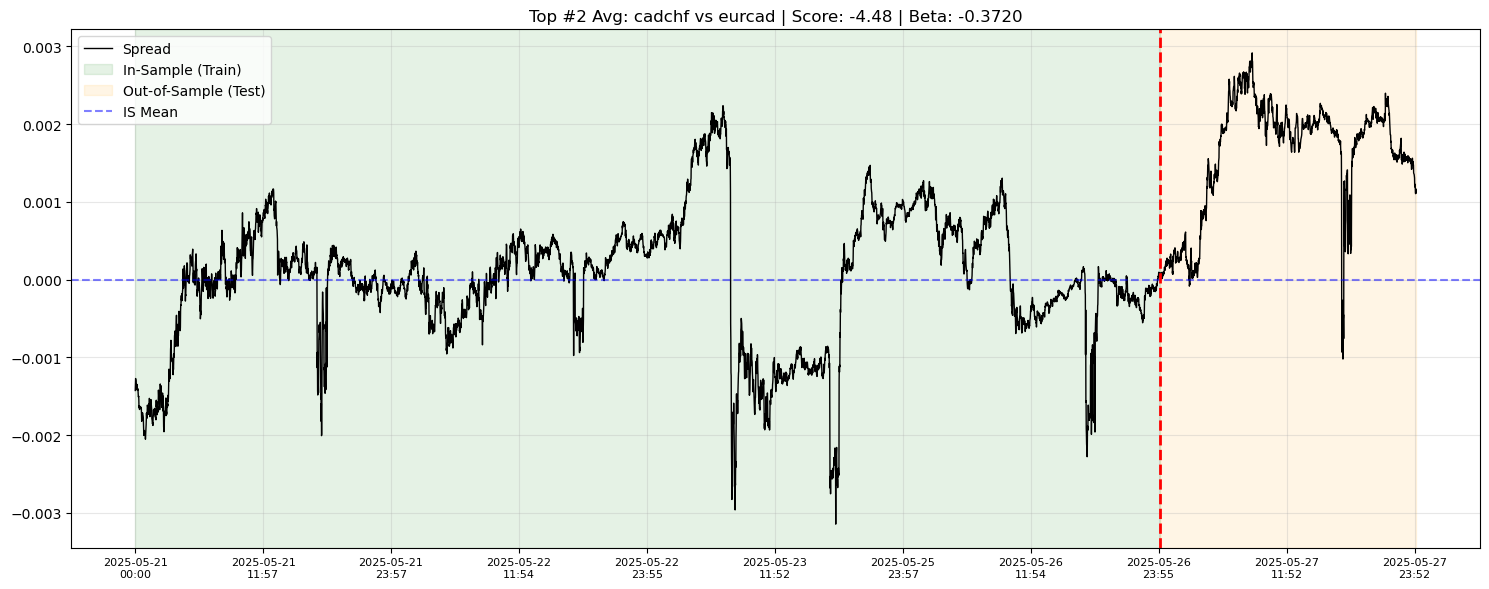


--- Rank 3: audjpy-nzdjpy (Mean: -4.15) ---


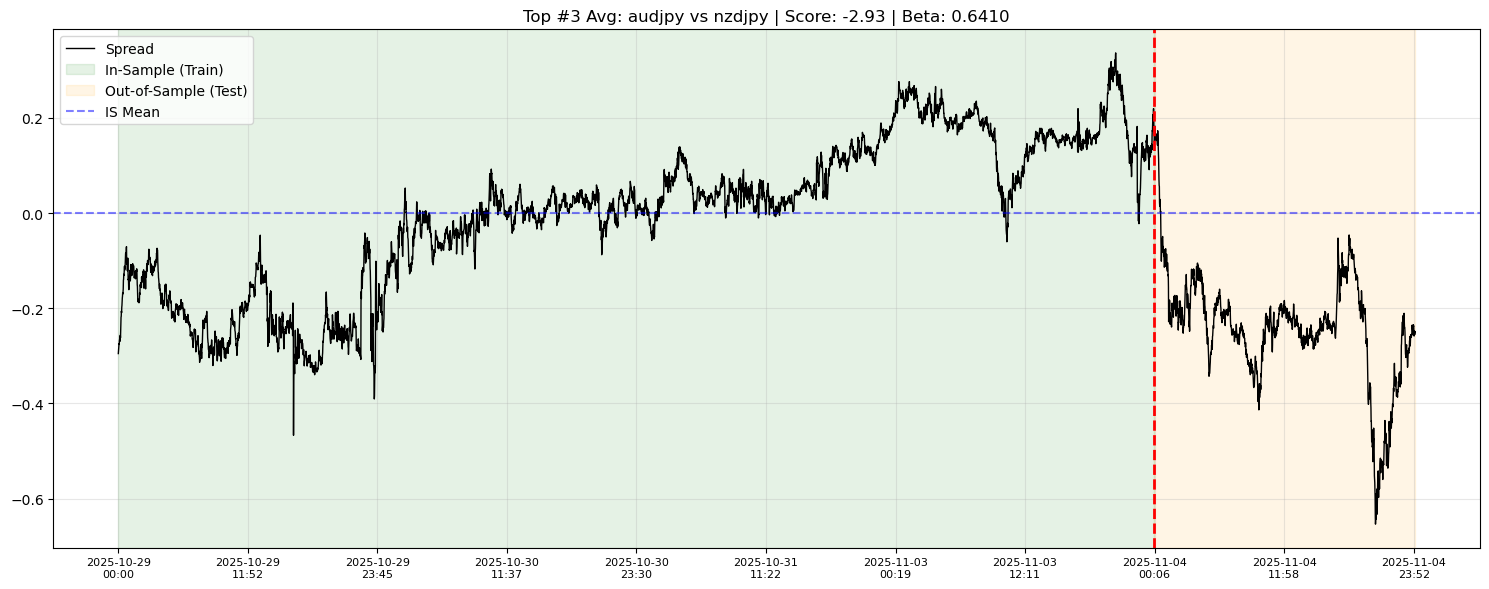


--- Rank 4: eurgbp-gbpchf (Mean: -3.86) ---


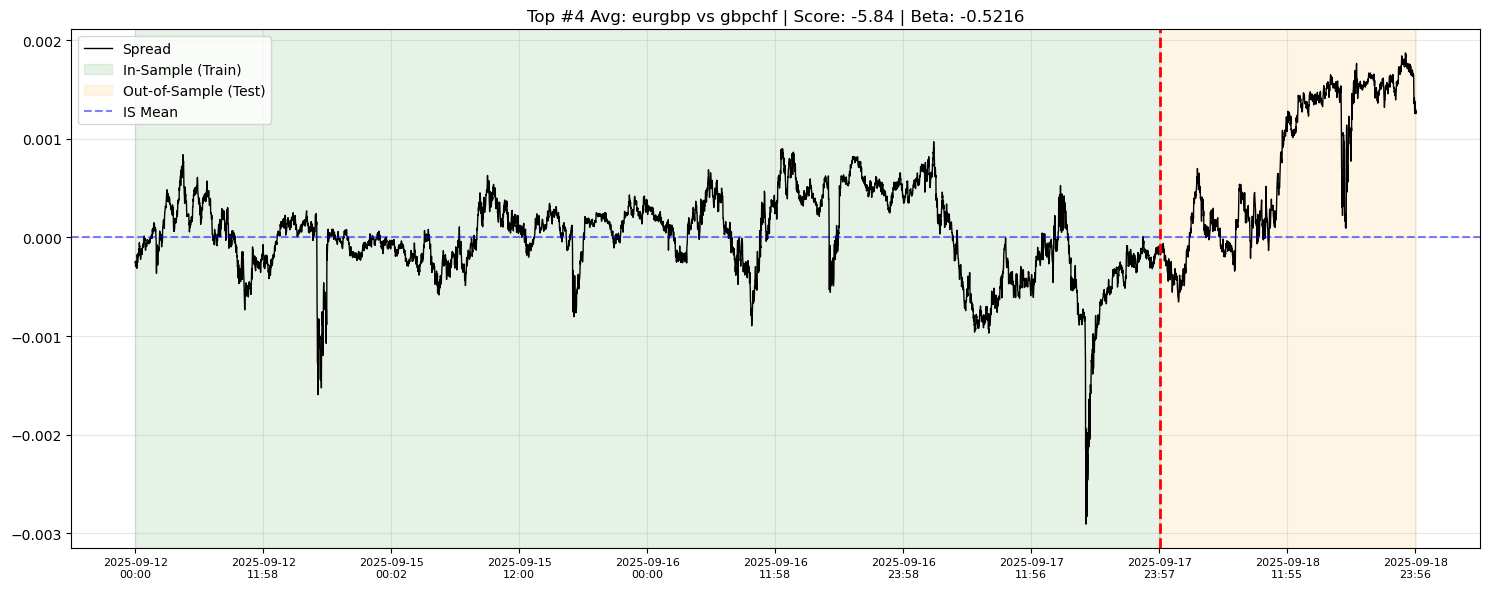


--- Rank 5: chfjpy-eurjpy (Mean: -3.82) ---


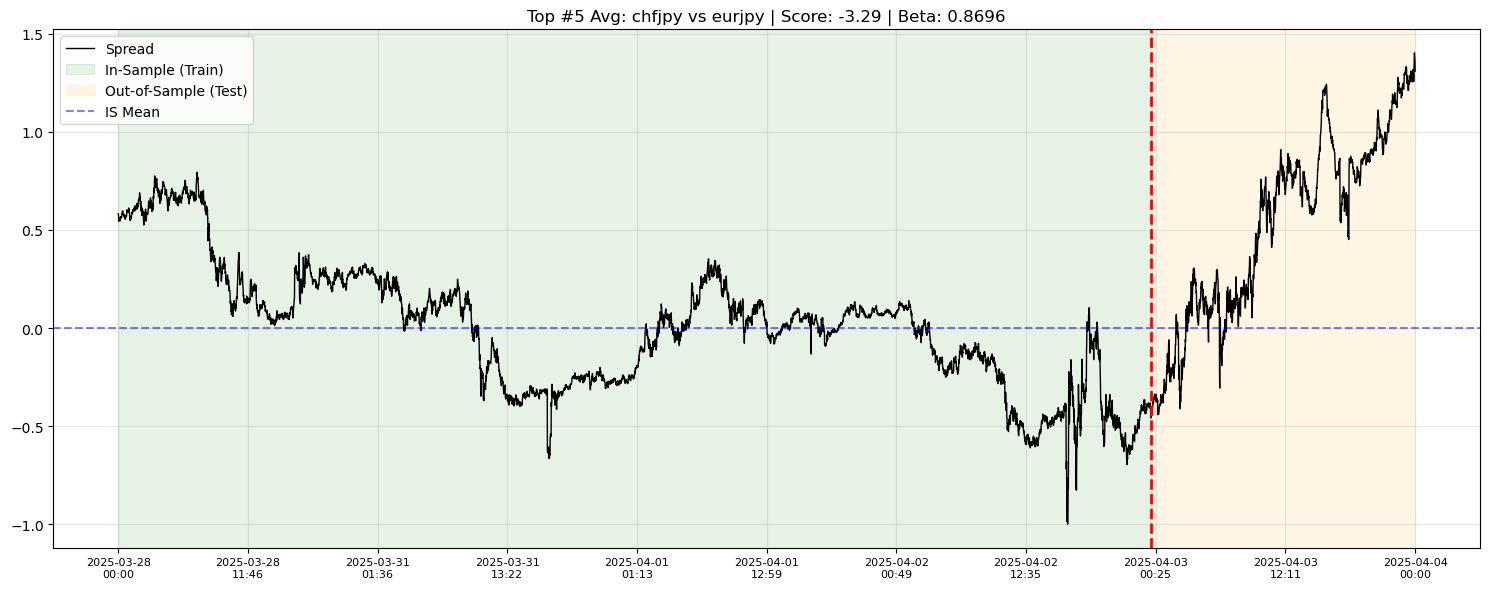


--- Rank 6: cadchf-eurchf (Mean: -3.80) ---


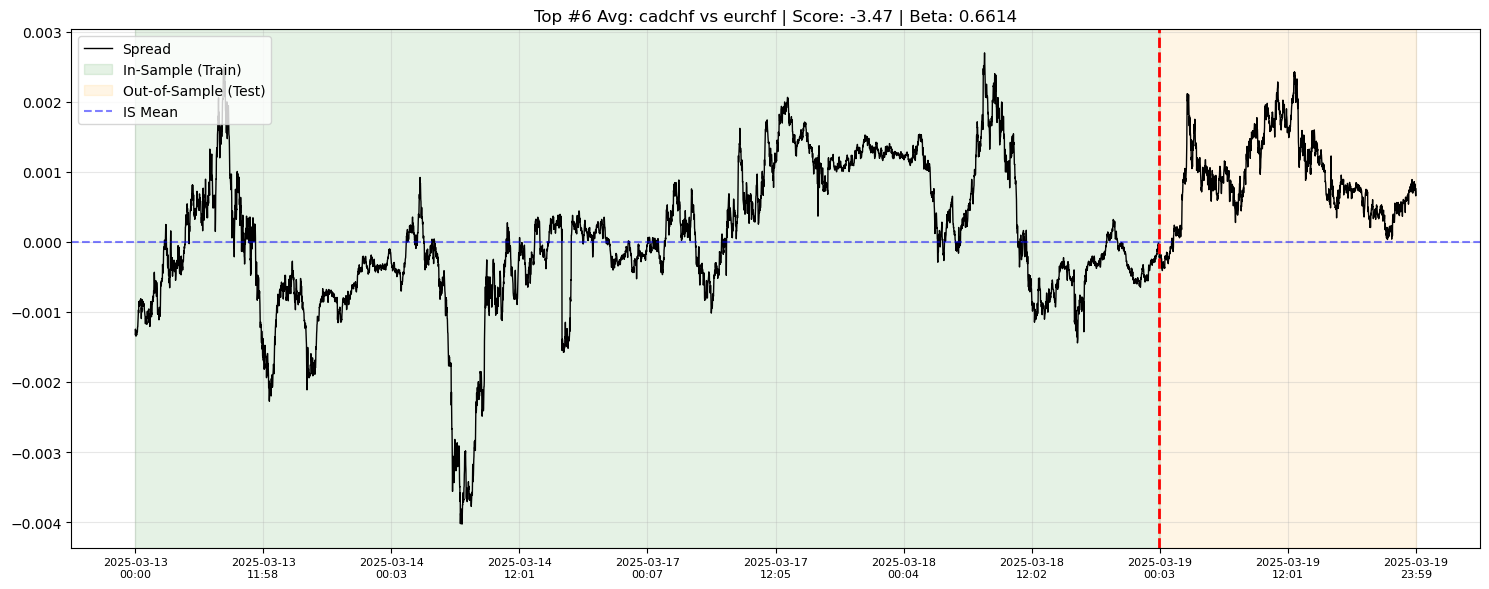


--- Rank 7: cadchf-usdchf (Mean: -3.80) ---


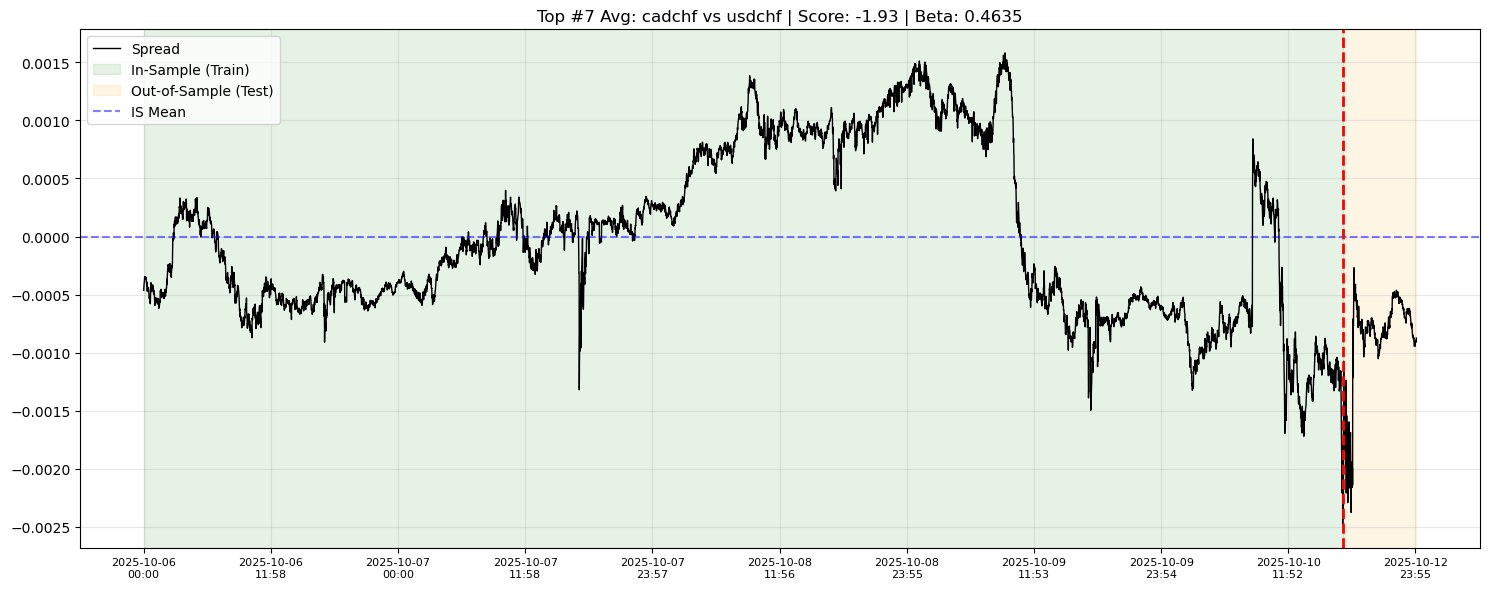


--- Rank 8: audchf-cadchf (Mean: -3.78) ---


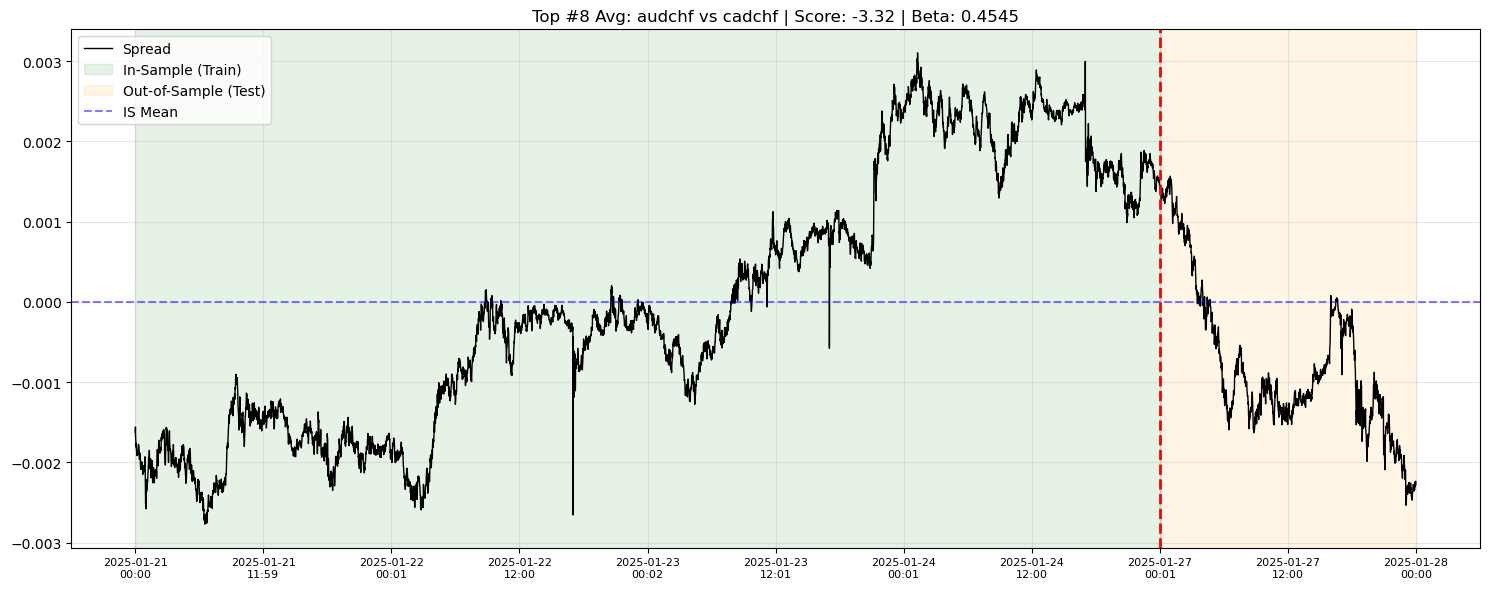


--- Rank 9: audnzd-cadchf (Mean: -3.70) ---


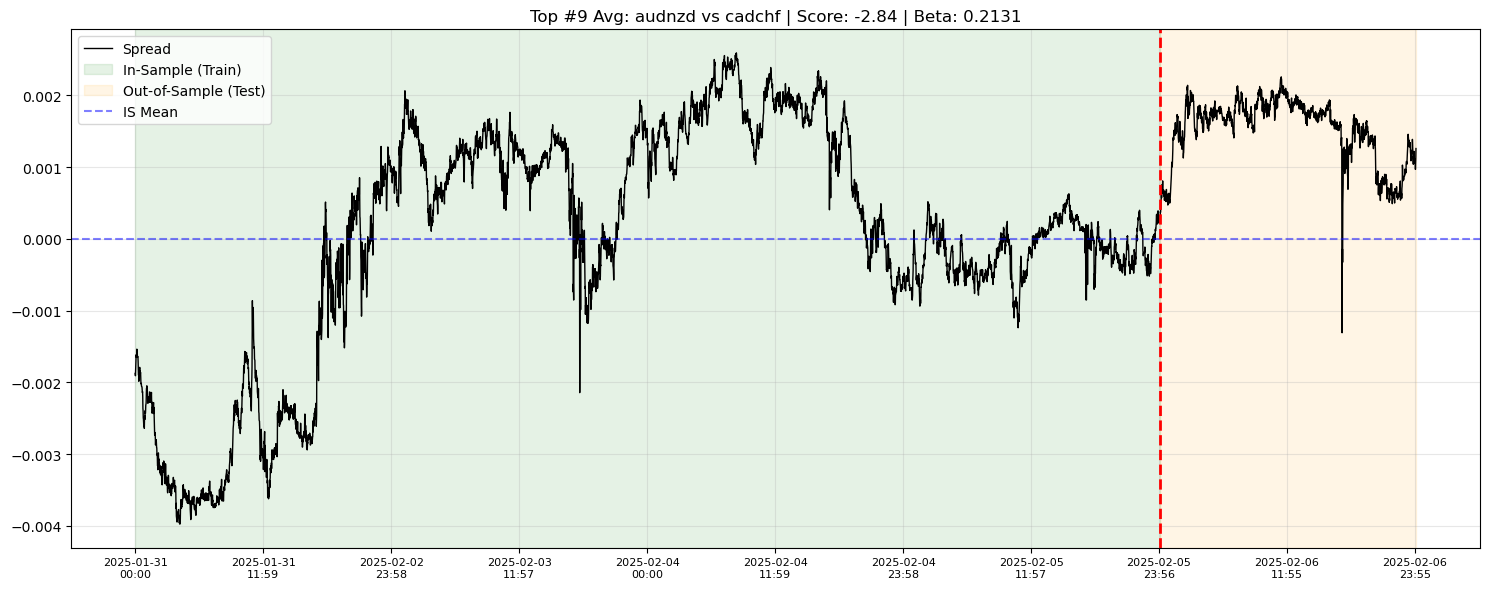


--- Rank 10: eurchf-gbpchf (Mean: -3.69) ---


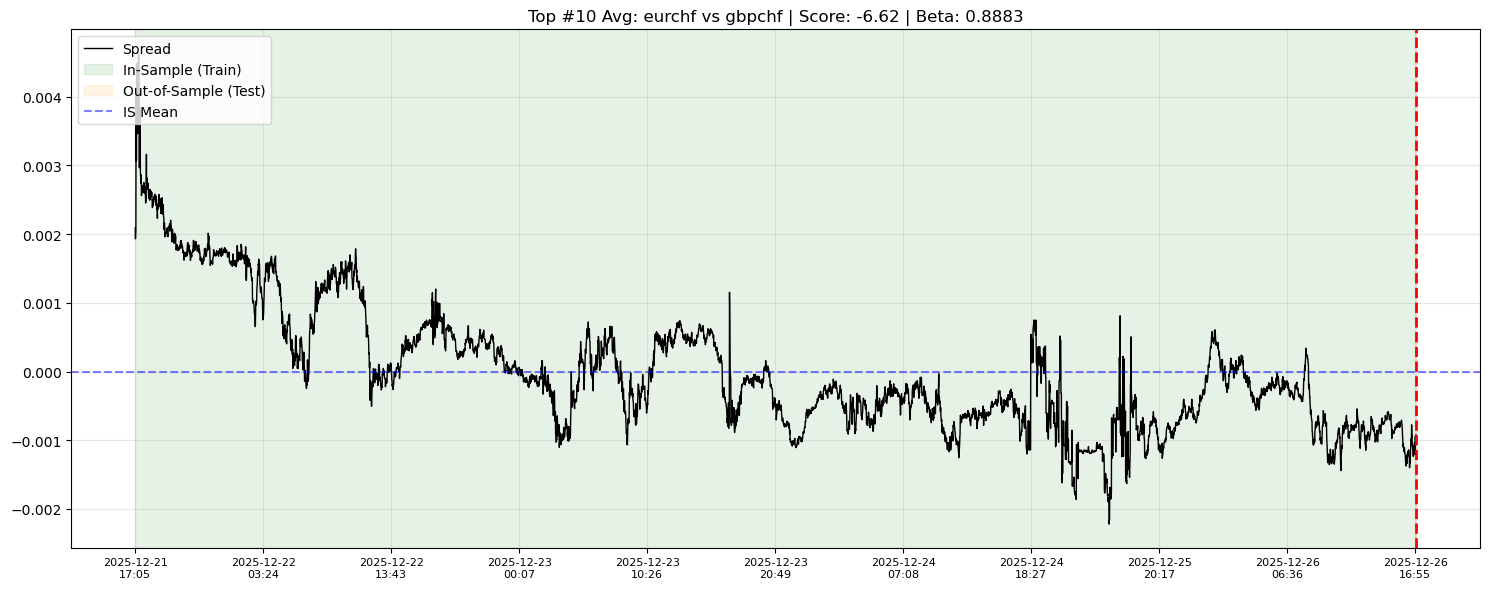


--- Rank 11: audchf-eurnzd (Mean: -3.63) ---


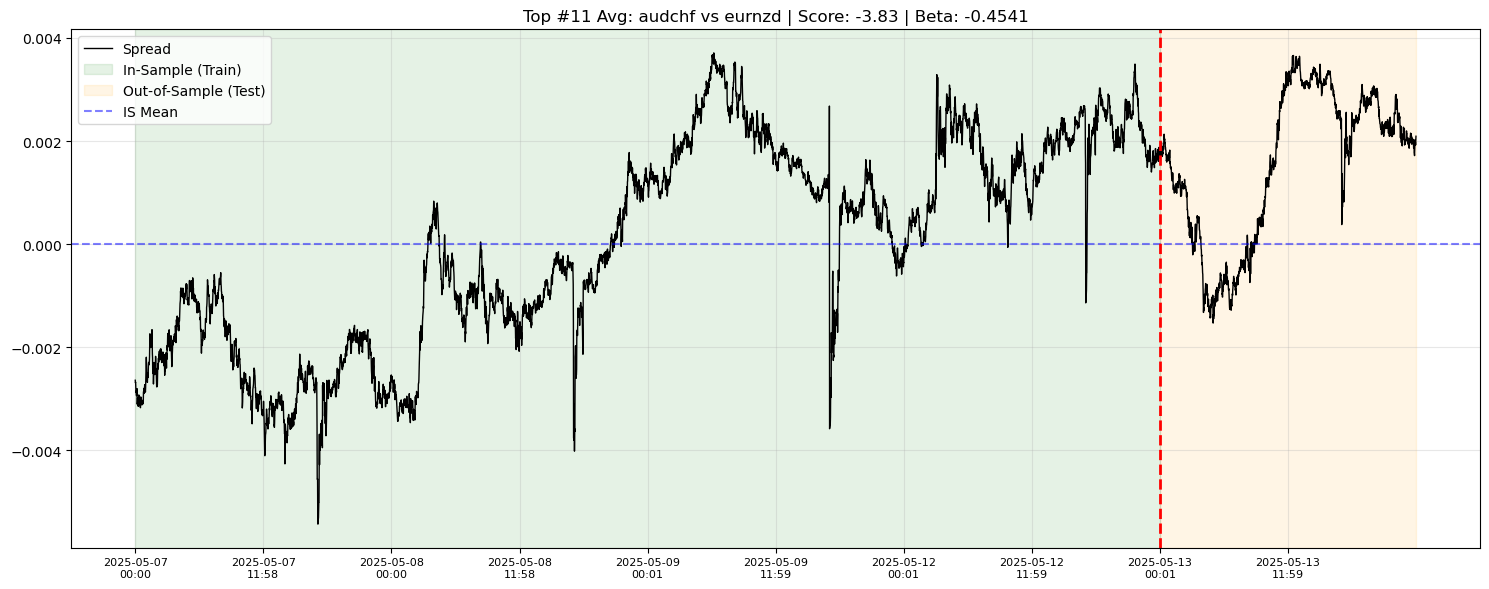


--- Rank 12: cadchf-gbpchf (Mean: -3.61) ---


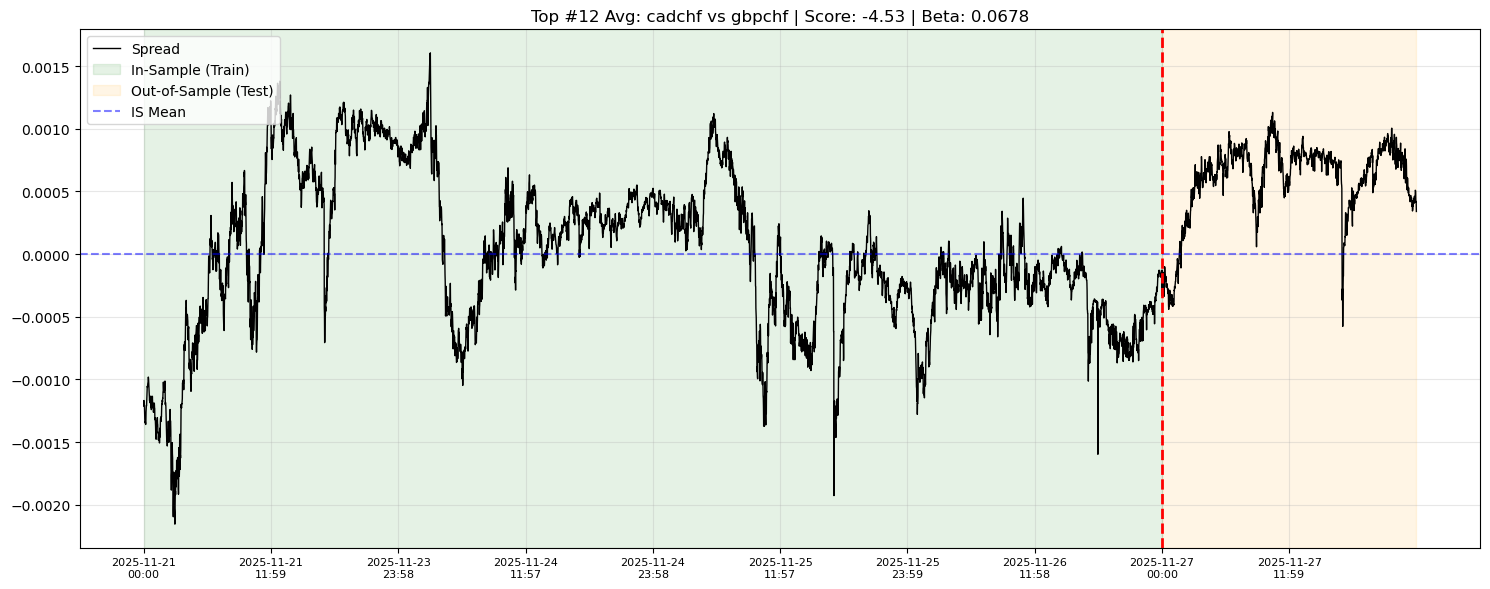


--- Rank 13: audchf-nzdjpy (Mean: -3.61) ---


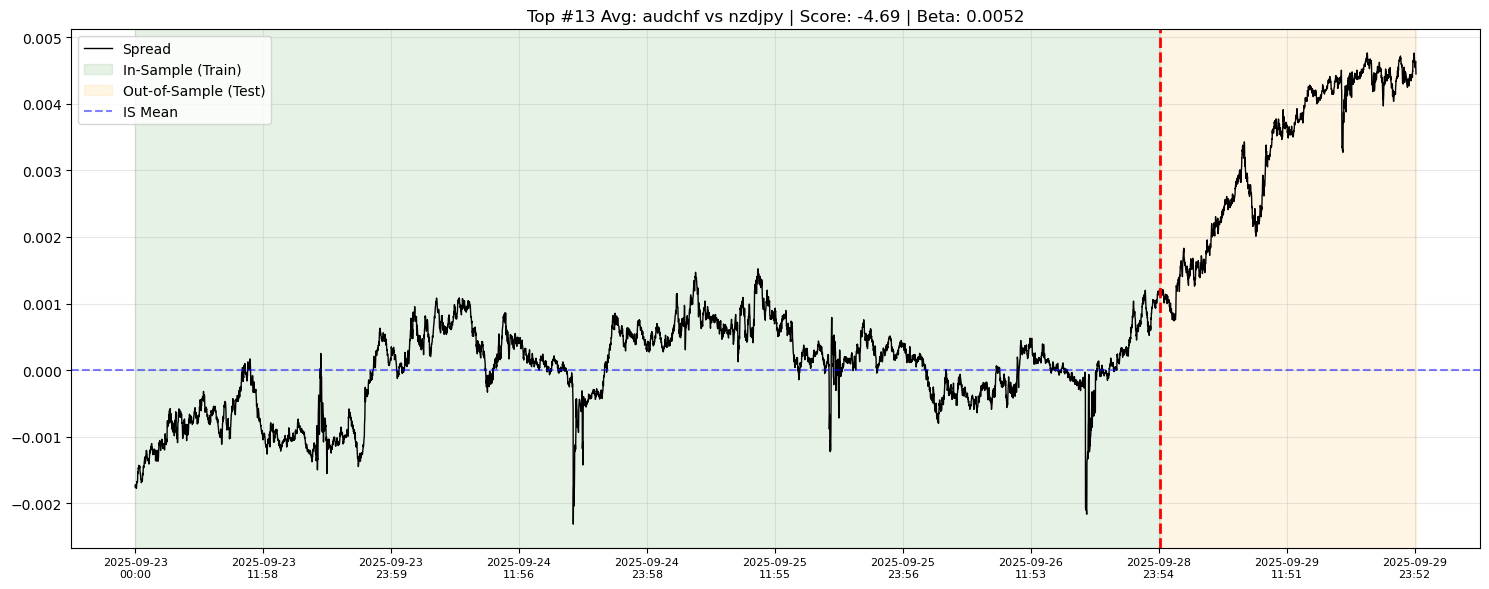


--- Rank 14: cadchf-gbpcad (Mean: -3.59) ---


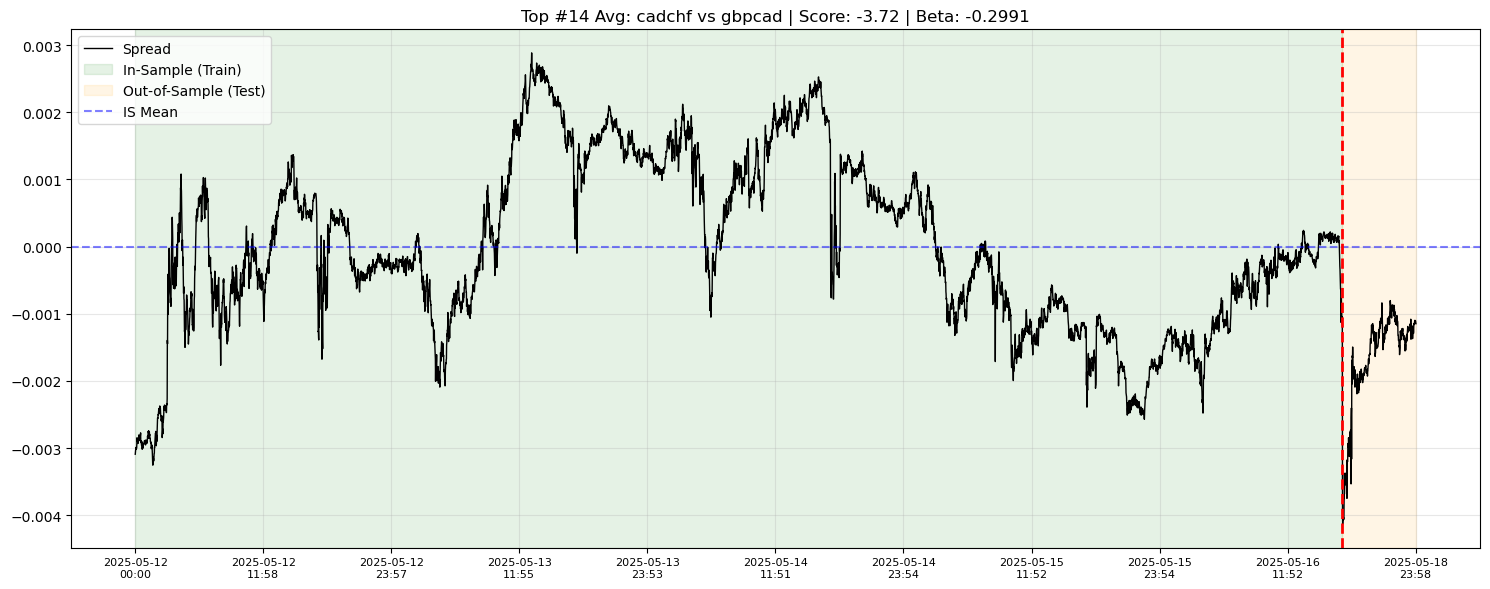


--- Rank 15: audchf-gbpaud (Mean: -3.57) ---


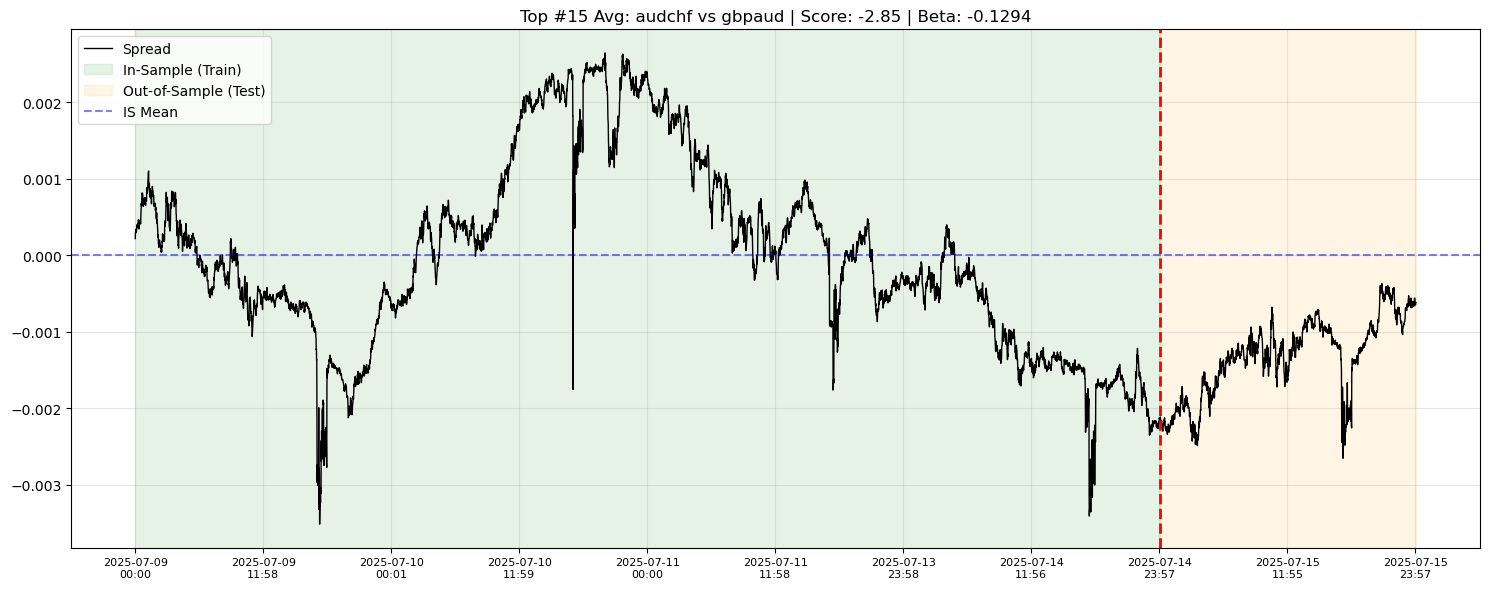


--- Rank 16: audnzd-eurchf (Mean: -3.57) ---


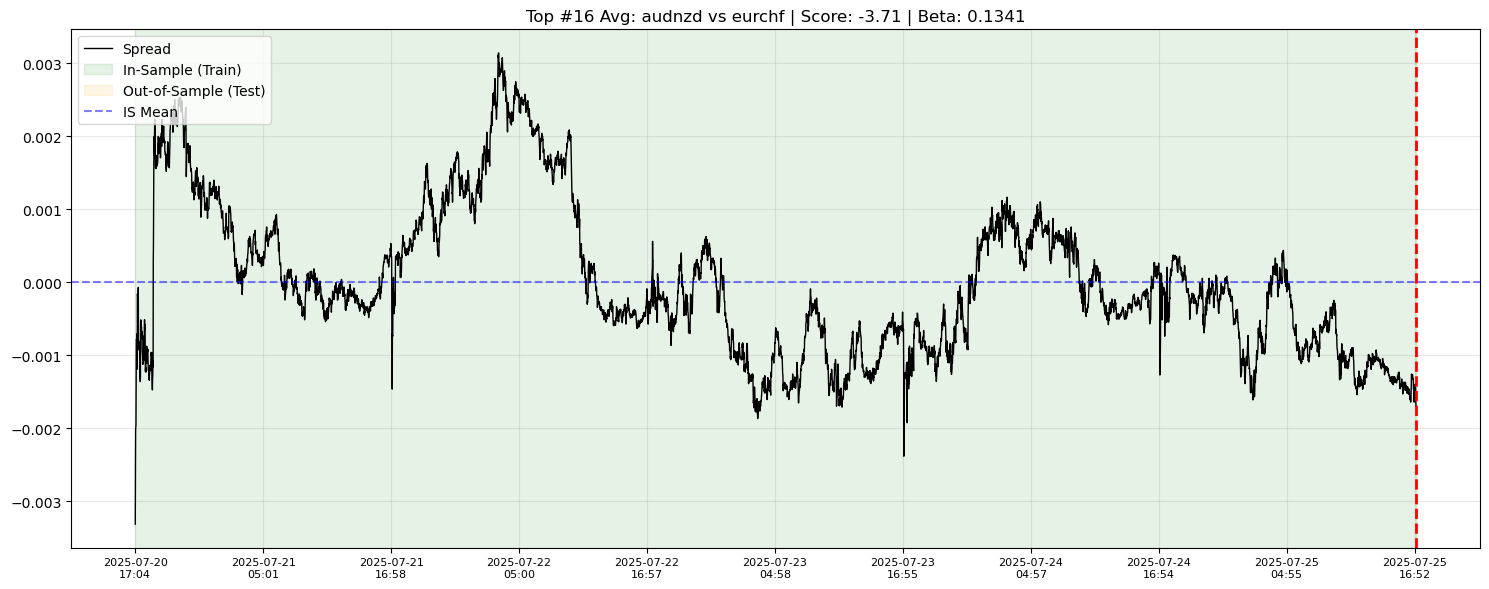


--- Rank 17: cadchf-eurgbp (Mean: -3.56) ---


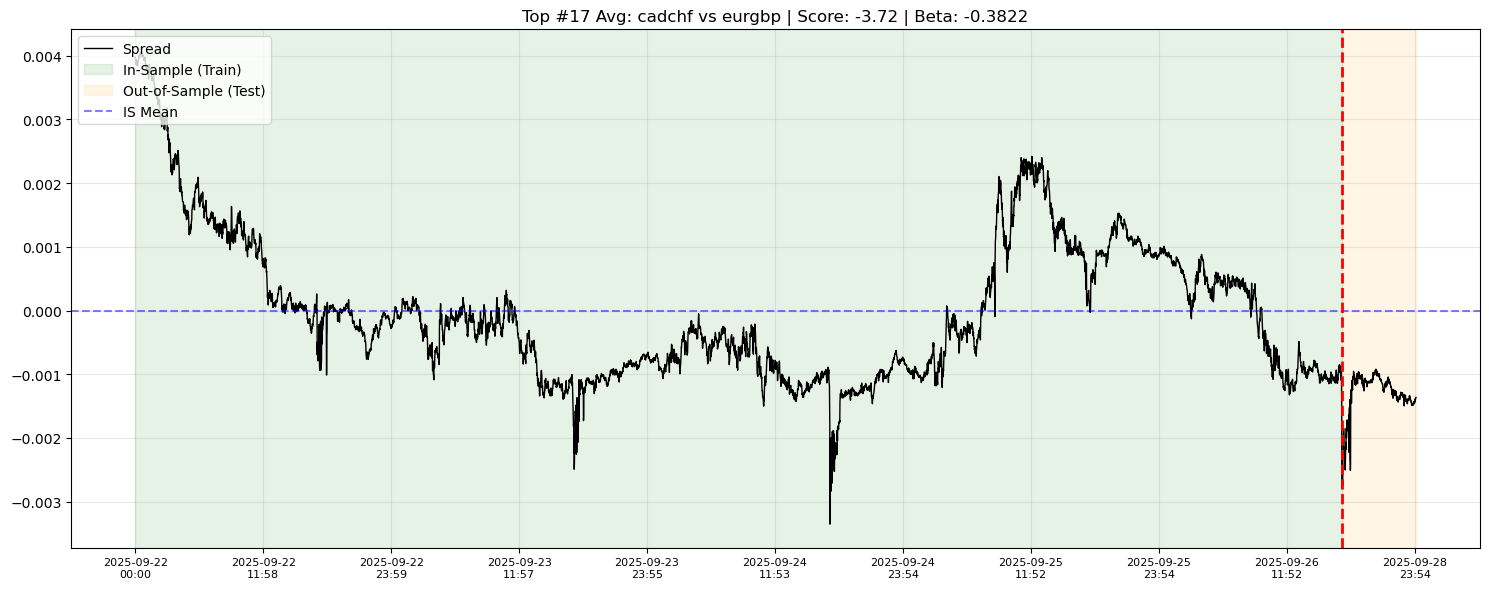


--- Rank 18: chfjpy-gbpjpy (Mean: -3.55) ---


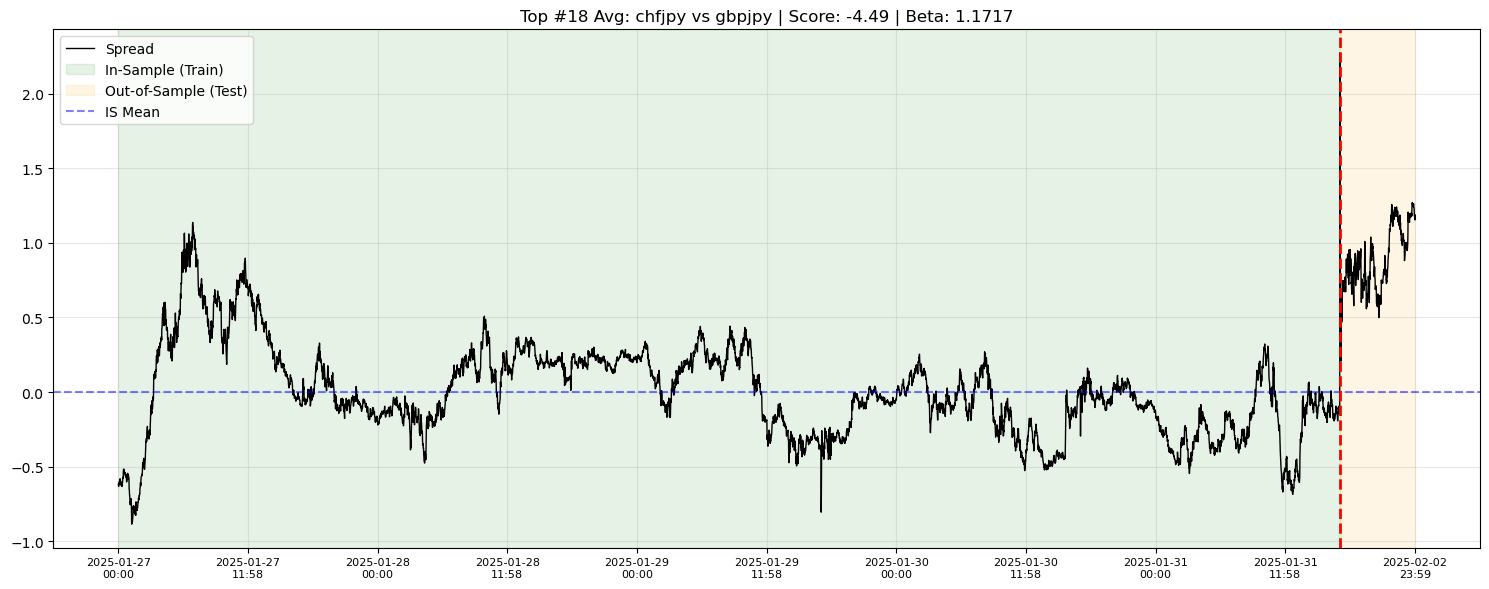


--- Rank 19: audchf-audnzd (Mean: -3.54) ---


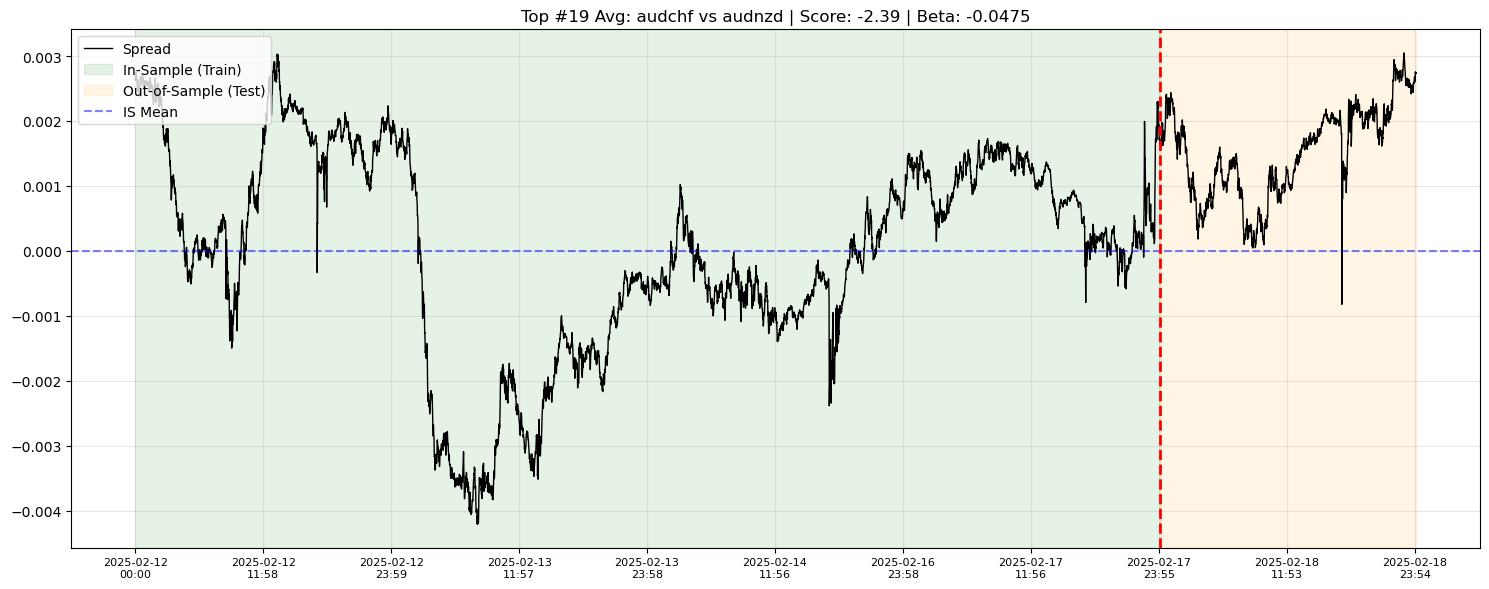


--- Rank 20: cadchf-cadjpy (Mean: -3.53) ---


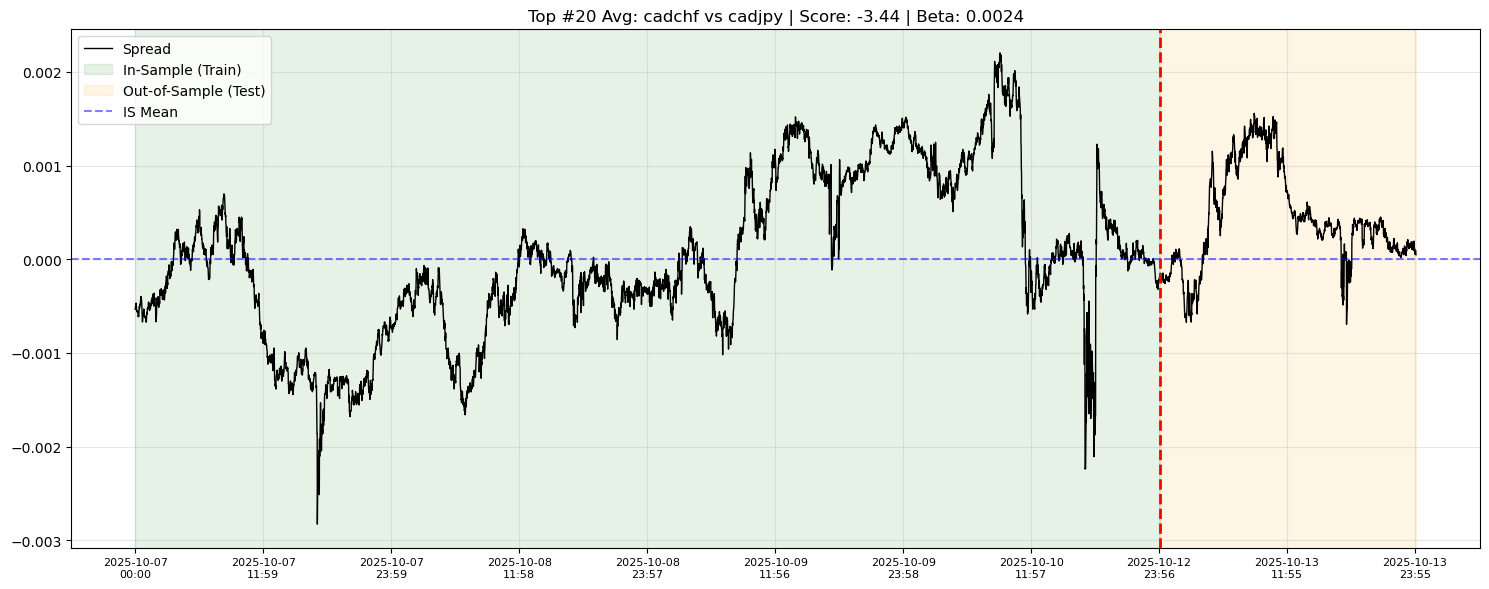

In [23]:
# --- NEW LOGIC: Top 20 by Average Score ---

# 1. Aggregate scores by pair
print("Calculating average scores for all pairs...")
pair_stats = {} # (p1, p2) -> list of scores

for day_data in daily_results:
    if day_data and 'results' in day_data:
        for res in day_data['results']:
            # Normalize pair key
            p1 = res['pair1']
            p2 = res['pair2']
            if p1 > p2:
                p1, p2 = p2, p1
            key = (p1, p2)
            
            if key not in pair_stats:
                pair_stats[key] = []
            
            # Use the score
            pair_stats[key].append(res['score'])

# 2. Compute Mean
pair_means = []
for key, scores in pair_stats.items():
    # Only consider pairs with enough data points (e.g. > 10 days)
    if len(scores) > 10:
        mean_score = np.mean(scores)
        pair_means.append((key, mean_score, len(scores)))

# 3. Sort by Mean Score (Ascending - lower is better/stronger cointegration)
pair_means.sort(key=lambda x: x[1])

# 4. Select Top 20
top_20 = pair_means[:20]

print()
print(f"Top 20 Pairs by Average Cointegration Score (over {len(daily_results)} days):")
for i, (key, mean, count) in enumerate(top_20, 1):
    print(f"{i}. {key[0]}-{key[1]}: Mean={mean:.4f} (Days={count})")

# 5. Visualize a random period for each of the Top 20
print()
print("Visualizing Random Periods for Top 20 Pairs...")

# Helper to find days for a specific pair
def get_days_for_pair(target_p1, target_p2):
    matches = []
    target_key = (target_p1, target_p2) if target_p1 < target_p2 else (target_p2, target_p1)
    
    for day in daily_results:
        if day and 'results' in day:
            for res in day['results']:
                p1 = res['pair1']
                p2 = res['pair2']
                current_key = (p1, p2) if p1 < p2 else (p2, p1)
                
                if current_key == target_key:
                     matches.append((day, res))
    return matches

for rank, (key, mean, count) in enumerate(top_20, 1):
    p1, p2 = key
    
    # Get all days for this pair
    available_days = get_days_for_pair(p1, p2)
    
    if available_days:
        # Pick one random day
        chosen_day, chosen_record = random.choice(available_days)
        
        print()
        print(f"--- Rank {rank}: {p1}-{p2} (Mean: {mean:.2f}) ---")
        process_and_plot(chosen_day, chosen_record, title_prefix=f"Top #{rank} Avg")
    else:
        print(f"No data found for {p1}-{p2}")
